In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import math
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm,trange

from shutil import rmtree

from scipy.signal import savgol_filter

from numpy.linalg import inv
from scipy.signal import butter,filtfilt
from scipy.stats import median_abs_deviation

In [16]:
def smoothing(df,window_size=17,order=3):
    df = df.copy()
    df = savgol_filter(df, len(df), order, mode='interp')  
    return df

def butter_lowpass_filter(data, cutoff, fs, order):
    data = data.values
    
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def normalize_angle(df,limit = np.pi):
    data = df.values
    data = np.where(data < limit, data ,data - limit)
    
    return data

def remove_outliers(signal_data, window_size, threshold):
    filtered_data = signal_data.copy()
    for i in range(window_size, len(signal_data) - window_size):
        window = signal_data[i - window_size: i + window_size + 1]
        median = np.median(window)
        mad = median_abs_deviation(window)
        if abs(signal_data[i] - median) > threshold * mad:
            filtered_data[i] = median
    
    # Special handling for the last frame
    last_frame = signal_data[-1]
    window = filtered_data[-2*window_size:-window_size]
    median = np.median(window)
    mad = median_abs_deviation(window)
    if abs(last_frame - median) > threshold * mad:
        filtered_data[-1] = median
    
    return filtered_data

In [17]:
BASE_DIR = '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/'
IMG_DIR = os.path.join(BASE_DIR,'output_3_pad/')


INF_DIR = os.path.join(BASE_DIR,'association_inference/')
data_path = [{'img':IMG_DIR+img,'inf':INF_DIR+inf
             } for img,inf in 
             zip(sorted(os.listdir(IMG_DIR)),
                 sorted([x for x in os.listdir(INF_DIR) if not x.endswith('angle.txt')])
                )]

In [18]:
len(data_path)

300

In [19]:
if os.path.exists(os.path.join(IMG_DIR,'..','label_smooth')):
    rmtree(os.path.join(IMG_DIR,'..','label_smooth'))

os.makedirs(os.path.join(IMG_DIR,'..','label_smooth'))

In [20]:
img_input_size = (512,512)

inf_header = ['h','w','l','z','alphax','alphay','conf','idx','cx','cy','xmin','ymin','xmax','ymax','id']

all_data = []
for j,data in tqdm(enumerate(data_path[:])):

    ann = pd.read_csv(data['inf'],sep = ' ',names=inf_header)
    for i in range(len(ann)):
        label = ann.iloc[i]

        label_dict = label.to_dict()
        label_dict['filename'] = data['inf']
        all_data.append(label_dict)


300it [00:00, 646.61it/s]


In [21]:
df_input = pd.DataFrame(all_data)
df_input = df_input.drop_duplicates(keep=False)
df_output = []

In [22]:
len(df_input['filename'].unique())

300

In [23]:
window_size = 5
order = 1

fs = 30.0
cutoff = 0.5

outlier_window = 30
threshold = np.pi/4

angle_columns = ['alphax','alphay']
smooth_columns = ['alphax', 'alphay','w','h','l','z']
result_columns = [x + '_smooth' for x in smooth_columns]
properties_columns = ['h','w','l']

save_columns = [x+'_smooth' if x in smooth_columns else x for x in inf_header ]

In [24]:
for fish_id in df_input['id'].unique():
    tmp = df_input[df_input['id']==fish_id].sort_values('idx')
    
    if len(tmp) < 15:
        continue

    for col in smooth_columns:
        
        if col in angle_columns:
            tmp[col] = normalize_angle(tmp[col],limit=np.pi)
            
#         tmp[col+'_smooth'] = smoothing(tmp[col],window_size=window_size,order=order)
        tmp[col+'_filtered'] = remove_outliers(tmp[col].values, outlier_window, threshold)
        tmp[col+'_smooth'] = butter_lowpass_filter(tmp[col+'_filtered'], cutoff, fs, order)
        
        if col in properties_columns:
            tmp[col+'_smooth'] = tmp[col+'_smooth'].median()
    
    if len(df_output) == 0:
        df_output = tmp
    else:
        df_output =  pd.concat([df_output,tmp])


/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/_method

/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/_method

/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfin/.conda/envs/CenterNet/lib/python3.8/site-packages/numpy/core/_method

In [25]:
df_output = df_output.reset_index(drop=True)
len(df_output['filename'].unique())

300

In [26]:
filenames = list(df_output['filename'].unique())
for filename in filenames:
    df_file = df_output[df_output['filename']==filename]
    df_file = df_file[save_columns]
    
    name = os.path.basename(filename)
    save_path = os.path.join(IMG_DIR,'..','label_smooth',name)
    df_file.to_csv(save_path,header=False,sep=' ',index=False)

In [27]:
# (a + 180) % 360 - 180
test = df_output[df_output['id']==5].copy()

<AxesSubplot: >

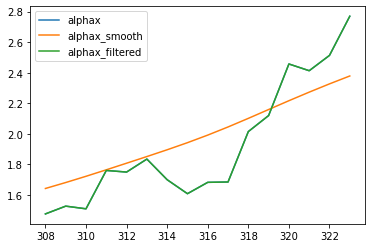

In [28]:
colu = 'alphax'
test[[colu,colu+'_smooth',colu+'_filtered']].plot()